In [42]:
import pandas as pd
import glob
import os
import csv
from datetime import datetime, timedelta
import json
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Big file

In [140]:
df = pd.read_csv('grouped_unrounded.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])

In [141]:
df.set_index('datetime', inplace=True)
df

,power
datetime,
2022-02-14 15:05:56.374,115.90
2022-02-14 15:05:56.865,116.25
2022-02-14 15:05:57.344,116.10
2022-02-14 15:05:57.826,115.80
2022-02-14 15:05:58.305,115.25
...,...
2022-06-13 09:19:20.444,79.80
2022-06-13 09:19:20.936,81.25
2022-06-13 09:19:21.415,80.80


### Fixing power difference

In [142]:
power_diff = 9.162812939836797
start_increase = "2022-05-23 09:48:48"
end_increase = "2022-05-24 14:00:00"

increased_section = df[start_increase : end_increase]
increased_section = increased_section.apply(lambda x: x - power_diff)

df.update(increased_section)

<AxesSubplot:xlabel='datetime'>

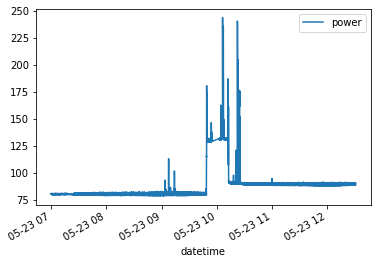

In [122]:
#Before
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

<AxesSubplot:xlabel='datetime'>

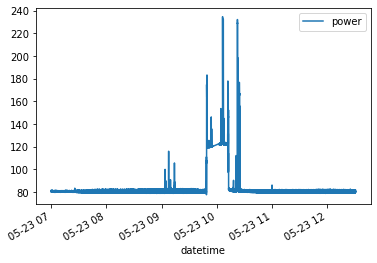

In [143]:
#After
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [144]:
df.to_csv("grouped_unrounded_adjusted.csv")

## Average power consumption

In [13]:
df_rounded = pd.read_csv('grouped_rounded_adjusted.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df_rounded['datetime'] = pd.to_datetime(df_rounded['datetime'])
df_rounded.set_index('datetime', inplace=True)
df_rounded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5900166 entries, 2022-02-14 15:05:56 to 2022-06-13 09:19:22
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 90.0 MB


In [14]:
df_unrounded = pd.read_csv('grouped_unrounded_adjusted.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df_unrounded['datetime'] = pd.to_datetime(df_unrounded['datetime'])
df_unrounded.set_index('datetime', inplace=True)
df_unrounded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11232088 entries, 2022-02-14 15:05:56.374000 to 2022-06-13 09:19:22.376000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 171.4 MB


In [15]:
with open("power/db_vmaf_yuv_2022-06-07.json") as f:
    vmaf_data = json.load(f)

# print(json.dumps(vmaf_data["libvpx-vp9"]["1"], indent=2))

times = [[qp["start_time"], qp["end_time"]] for qp in vmaf_data["libvpx-vp9"]["1"]["evaluated_qps"]] + [[vmaf_data["libvpx-vp9"]["1"]["target_encode"]["start_time"], vmaf_data["libvpx-vp9"]["1"]["target_encode"]["end_time"]]]

In [16]:
vmaf_data.keys()

dict_keys(['libvpx-vp9', 'libx264', 'libx265', 'libsvtav1', 'VVC'])

In [17]:
vids_flat = {}

for codec in vmaf_data.keys():
    vids = vmaf_data[codec]
    
    for i, vid in enumerate(vmaf_data[codec].values()):
        if "error" in vid:
            continue
        vid["codec"] = codec
        vids_flat[f"{i}-{codec}"] = vid 

### Calculations

In [18]:
one_vid_times = get_video_time(vids_flat["0-libvpx-vp9"])
one_vid_times

[['2022-05-02 15:40:31.537', '2022-05-02 15:41:04.308'],
 ['2022-05-02 15:41:49.071', '2022-05-02 15:42:17.777'],
 ['2022-05-02 15:43:02.430', '2022-05-02 15:43:25.563'],
 ['2022-05-02 15:44:11.118', '2022-05-02 15:44:30.494'],
 ['2022-05-02 15:45:15.068', '2022-05-02 15:45:31.851'],
 ['2022-05-02 15:46:15.988', '2022-05-02 15:46:34.355']]

In [19]:
# df_rounded[one_vid_times[0][0] : one_vid_times[0][1]]

In [20]:
(datetime.strptime(one_vid_times[0][1], "%Y-%m-%d %H:%M:%S.%f") - datetime.strptime(one_vid_times[0][0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()

32.771

In [21]:
energy = get_energy_video(df_rounded, one_vid_times)

In [22]:
energy

[power    3756.251742
 dtype: float64,
 power    3304.296399
 dtype: float64,
 power    2671.35678
 dtype: float64,
 power    2250.369432
 dtype: float64,
 power    1949.565727
 dtype: float64,
 power    2122.567855
 dtype: float64]

In [23]:
def get_energy_video(df, times):
    #average power in watts
    avg_power = [df[time[0] : time[1]].mean() for time in times]
    #energy in joules
    energy = [power * (datetime.strptime(time[1], "%Y-%m-%d %H:%M:%S.%f") - datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds() for power, time in zip(avg_power, times)] #??
    
    return energy

def get_diff_percentage(val1, val2):
    return abs((val1 - val2) / val2) * 100

In [24]:
get_video_time = lambda video: [[qp["start_time"], qp["end_time"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time"], video["target_encode"]["end_time"]]]

video_times = [get_video_time(video) for video in vids_flat.values()]

In [25]:
avg_energy_unr = [get_energy_video(df_unrounded, time) for time in video_times]
# print(avg_powers_unr[0])

avg_energy_r   = [get_energy_video(df_rounded, time) for time in video_times]
# print(avg_powers_r[0])

# percentage_diffs_power = [get_diff_percentage(unr, r) for unr, r in zip(avg_powers_unr, avg_powers_r)]
# print(percentage_diffs_power[0])

In [26]:
evaluated_qp_energy = [sum(energy[:-1])[0] for energy in avg_energy_unr]
target_encode_energy = [energy[-1][0] for energy in avg_energy_unr]

In [63]:
video_names = [video['video_name'] for video in vids_flat.values()]
res = [video['resolution'] for video in vids_flat.values()]
codec = [video['codec'] for video in vids_flat.values()]
genre = [name.split("_")[0] for name in video_names]
bitrate = [video['target_encode']['bitrate'] for video in vids_flat.values()]
encoding_energy = [qp + target for qp, target in zip(evaluated_qp_energy, target_encode_energy)]

d = {"codec": codec, "video_name": video_names, "genre": genre, "resolution": res, "target bitrate": bitrate, "evaluated qp energy (J)": evaluated_qp_energy, "target encode energy (J)": target_encode_energy, "encoding energy (J)": encoding_energy}

powers_df = pd.DataFrame(data = d)

powers_df

,codec,video_name,genre,resolution,bitrate,evaluated qp energy (J),target encode energy (J),encoding energy (J)
0,libvpx-vp9,Animation_1080P-05f8,Animation,360,284.8130,13925.956660,2126.845432,1.605280e+04
1,libvpx-vp9,Animation_1080P-05f8,Animation,720,994.4860,23546.986091,5065.060267,2.861205e+04
2,libvpx-vp9,Animation_1080P-05f8,Animation,1080,1759.7110,64129.589067,10819.900074,7.494949e+04
3,libvpx-vp9,CoverSong_1080P-0188,CoverSong,360,271.0210,28572.139645,3711.859922,3.228400e+04
4,libvpx-vp9,HowTo_1080P-0267,HowTo,360,265.2110,6421.879718,1502.937469,7.924817e+03
...,...,...,...,...,...,...,...,...
1908,VVC,LyricVideo_1080P-63d9,LyricVideo,1080,1818.8465,390560.030743,96583.950777,4.871440e+05
1909,VVC,NewsClip_1080P-4241,NewsClip,1080,1735.2056,566266.483218,122857.714010,6.891242e+05
1910,VVC,TelevisionClip_1080P-5278,TelevisionClip,1080,1628.9615,524742.145847,101046.623594,6.257888e+05
1911,VVC,Animation_1080P-4be3,Animation,1080,1997.7283,971056.131527,159009.673517,1.130066e+06


In [15]:
# powers_df.sort_values(by="power_unrounded", ascending=False)
print("360p")
display(powers_df[powers_df["resolution"] == 360].groupby(["codec"]).mean().sort_values(by="evaluated qp energy (J)", ascending=False))
print("720p")
display(powers_df[powers_df["resolution"] == 720].groupby(["codec"]).mean().sort_values(by="evaluated qp energy (J)", ascending=False))
print("1080p")
display(powers_df[powers_df["resolution"] == 1080].groupby(["codec"]).mean().sort_values(by="evaluated qp energy (J)", ascending=False))

360p


,resolution,evaluated qp energy (J),target encode energy (J)
codec,,,
libvpx-vp9,360.0,12345.546087,2194.560301
libx265,360.0,3223.756436,683.546239
libsvtav1,360.0,3016.598068,544.363159
libx264,360.0,633.983669,126.481959


720p


,resolution,evaluated qp energy (J),target encode energy (J)
codec,,,
libvpx-vp9,720.0,25943.723185,4970.996017
libsvtav1,720.0,7126.171201,1322.392551
libx265,720.0,6662.913739,1389.998720
libx264,720.0,1611.773882,320.349600


1080p


,resolution,evaluated qp energy (J),target encode energy (J)
codec,,,
VVC,1080.0,483643.295155,107013.858792
libvpx-vp9,1080.0,55884.599650,10192.059778
libsvtav1,1080.0,14821.962529,2808.325042
libx265,1080.0,12144.448252,2393.061530
libx264,1080.0,3539.398507,659.867418


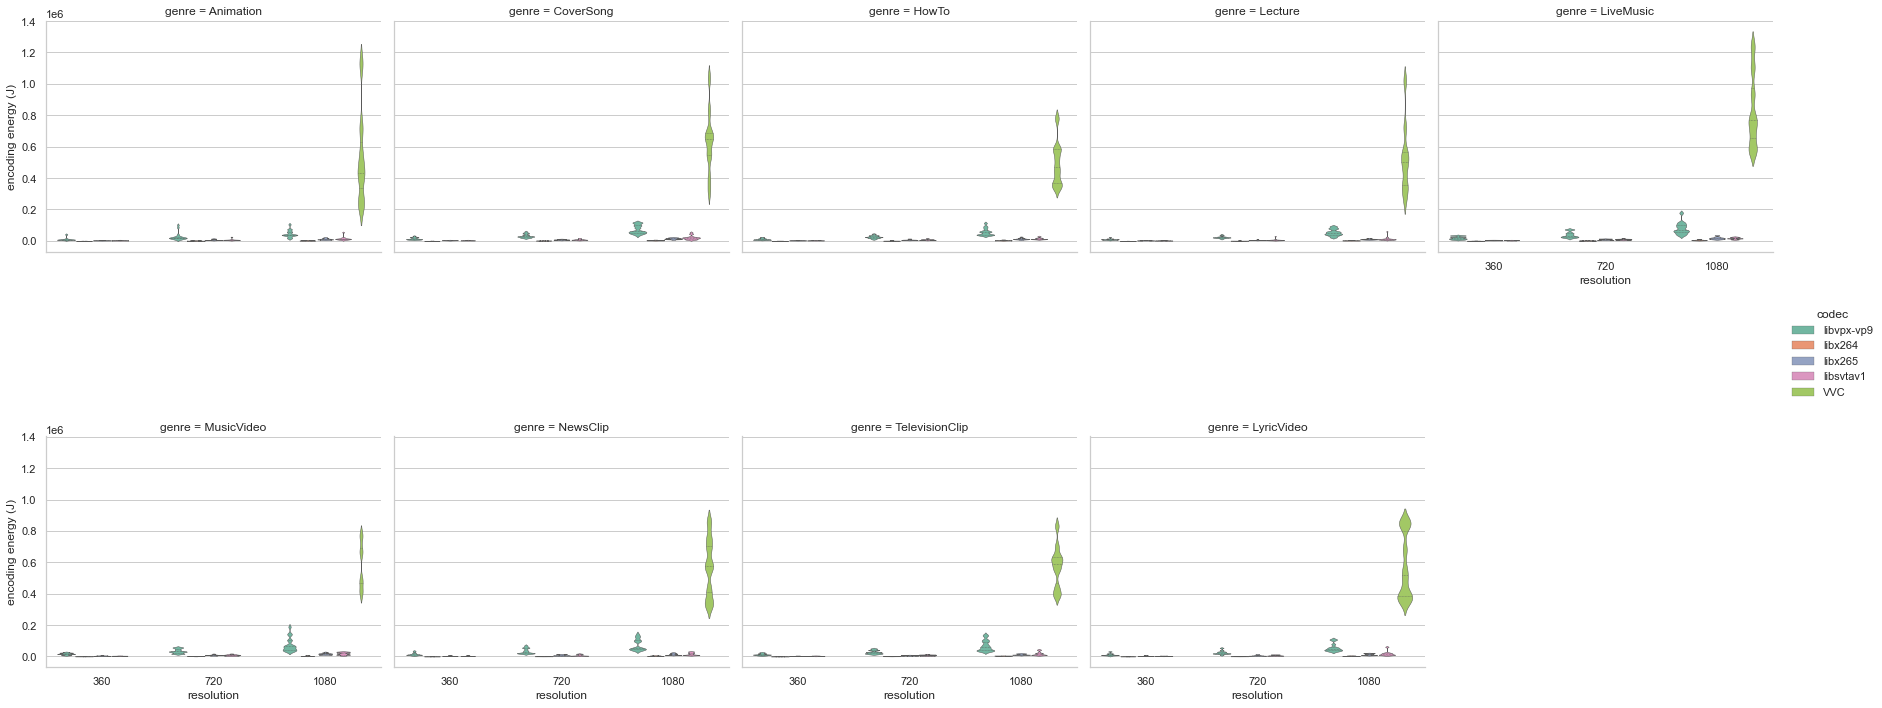

In [55]:
sns.catplot(x="resolution", y="encoding energy (J)", col="genre", hue="codec",
                    data=powers_df, palette="Set2", scale="count", inner="quartile",
                    scale_hue=False, bw=.2, kind="violin",col_wrap=5,linewidth=.5)
plt.subplots_adjust(hspace=0.8)
plt.savefig("res_vs_encoding_energy_violin.pdf")

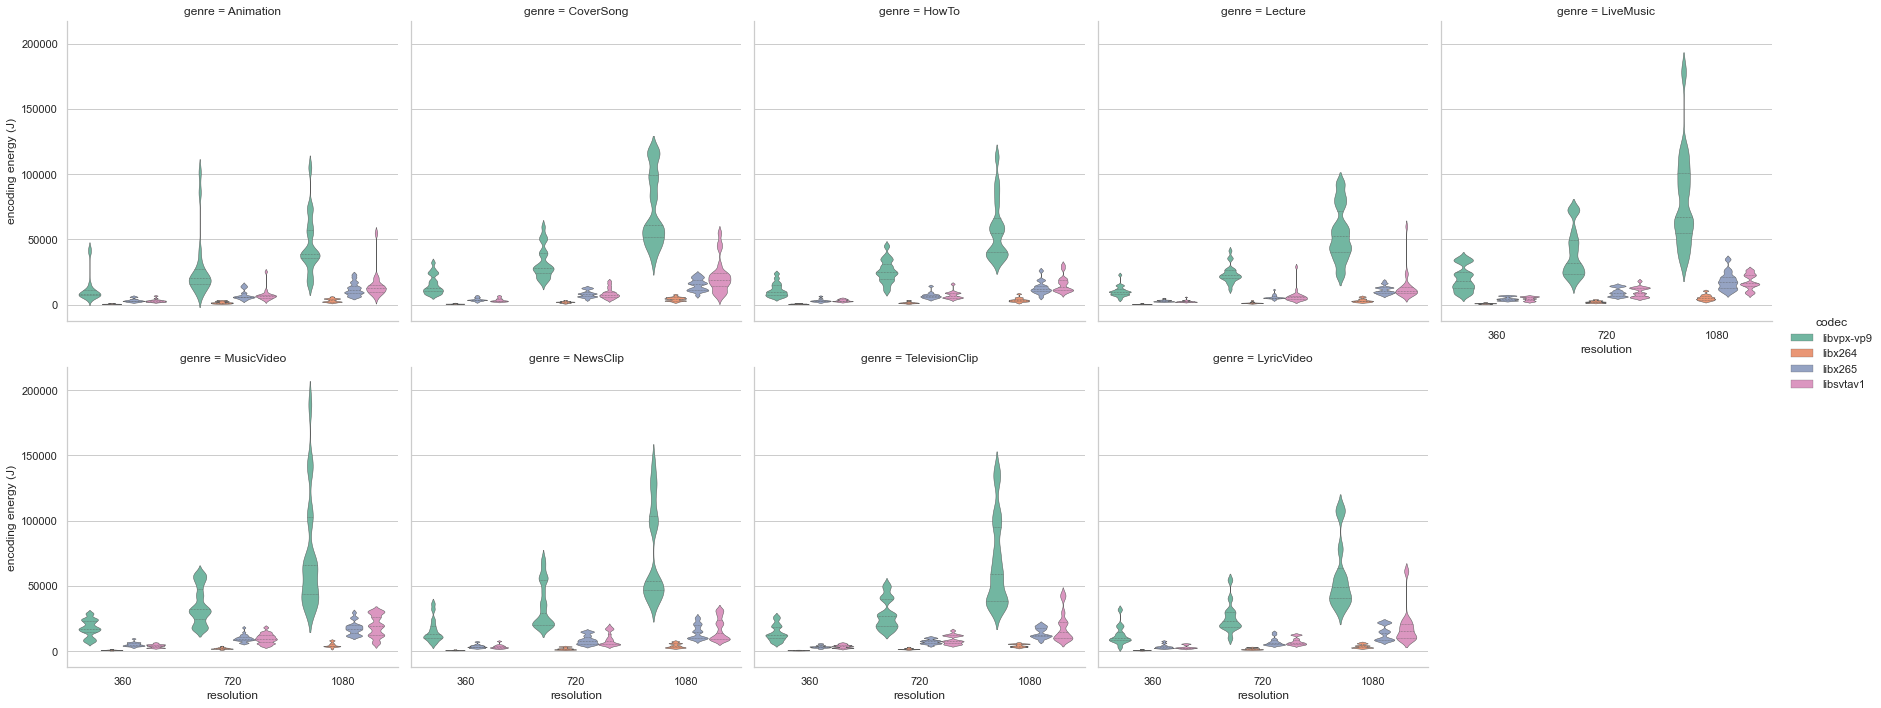

In [64]:
power_df_no_vvc = powers_df[powers_df.codec != "VVC"]
sns.catplot(x="resolution", y="encoding energy (J)", col="genre", hue="codec",
                    data=power_df_no_vvc, palette="Set2", scale="count", inner="quartile",
                    scale_hue=False, bw=.2, kind="violin",col_wrap=5,linewidth=.5)
plt.savefig("res_vs_encoding_energy_violin_no_vvc.pdf")

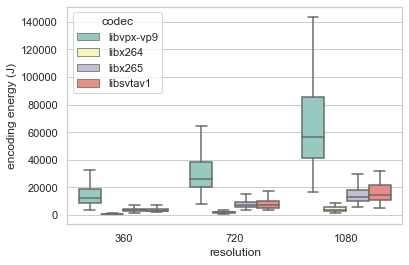

In [68]:
sns.boxplot(x="resolution", y="encoding energy (J)", hue="codec",
                 data=power_df_no_vvc, palette="Set3", showfliers = False)
plt.savefig("res_vs_encoding_energy_box_no_vvc.pdf")

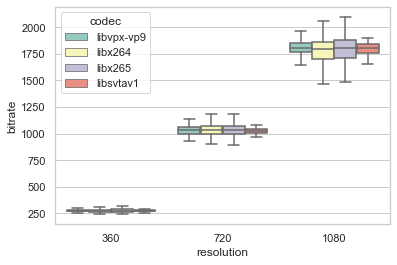

In [70]:
sns.boxplot(x="resolution", y="bitrate", hue="codec",
                 data=power_df_no_vvc, palette="Set3", showfliers = False)
plt.savefig("bitrate_vs_encoding_energy_box_no_vvc.pdf")

<AxesSubplot:xlabel='codec'>

<AxesSubplot:xlabel='codec'>

<AxesSubplot:xlabel='codec'>

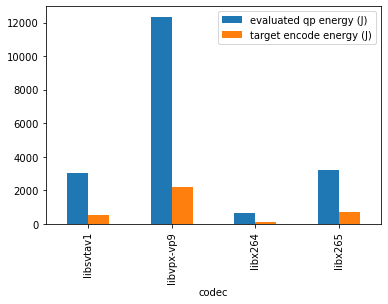

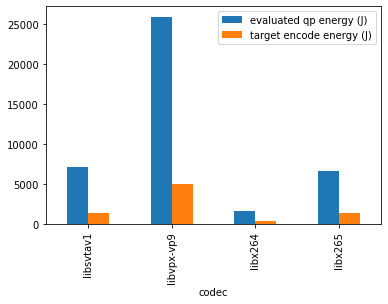

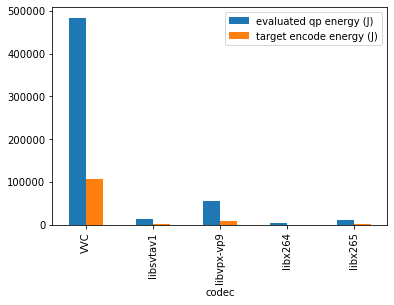

In [42]:
display((powers_df[powers_df["resolution"] == 360].groupby(["codec"]).mean())[["evaluated qp energy (J)", "target encode energy (J)"]].plot(kind="bar"))
display((powers_df[powers_df["resolution"] == 720].groupby(["codec"]).mean())[["evaluated qp energy (J)", "target encode energy (J)"]].plot(kind="bar"))
display((powers_df[powers_df["resolution"] == 1080].groupby(["codec"]).mean())[["evaluated qp energy (J)", "target encode energy (J)"]].plot(kind="bar"))

### Average power difference

In [13]:
powers_df["power difference"].mean()

0.6043111460959815

### Size Difference

In [15]:
rounded_mem = df_rounded.memory_usage(deep=True).sum()
unrounded_mem = df_unrounded.memory_usage(deep=True).sum()

print(f"Difference in memory usage: {(rounded_mem - unrounded_mem) / ((rounded_mem + unrounded_mem) / 2) * 100}")

rounded_file_size = 160007256
unrounded_file_size = 349845153

print(f"Difference in file size: {(rounded_file_size - unrounded_file_size) / ((rounded_file_size + unrounded_file_size) / 2) * 100}")

Difference in memory usage: -62.24425577626855
Difference in file size: -74.46778465648084


In [19]:
print(f"Unrounded file size is {unrounded_file_size/rounded_file_size}x larger")
print(f"Unrounded memory requirement is {unrounded_mem/rounded_mem}x more")

Unrounded file size is 2.186433051511114x larger
Unrounded memory requirement is 1.9036901673613928x more


In [9]:
for vid in vids_flat.values():
    video_times = get_video_time(vid)
    energies = get_energy_video(df_unrounded, video_times)
    
    evaluated_qp_energy = sum(energies[:-1])[0]
    target_encode_energy = energies[-1][0]
    
    for i, qp in enumerate(vid["evaluated_qps"]):
        qp["energy"] = energies[i][0]
        
    vid["target_encode"]["energy"] = target_encode_energy
    
    vid["evaluated_qp_energy"] = evaluated_qp_energy
    
vids_flat

{'0-libvpx-vp9': {'video_name': 'Animation_1080P-05f8',
  'resolution': 360,
  'evaluated_qps': [{'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_27.mp4',
    'bitrate': 1650.553,
    'start_time': '2022-05-02 15:40:31.537',
    'end_time': '2022-05-02 15:41:04.308',
    'qp': 27,
    'vmaf': 92.546579,
    'start_time_vmaf': '2022-05-02 15:41:05.883',
    'end_time_vmaf': '2022-05-02 15:41:48.925',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3758.9199394736843},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_33.mp4',
    'bitrate': 1058.271,
    'start_time': '2022-05-02 15:41:49.071',
    'end_time': '2022-05-02 15:42:17.777',
    'qp': 33,
    'vmaf': 90.232278,
    'start_time_vmaf': '2022-05-02 15:42:19.354',
    'end_time_vmaf': '2022-05-02 15:43:02.277',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3306.9503373333337},
   {'output_video_file_pat

In [74]:
test_dict = {}

for vid in vids_flat.values():
    test_dict[f"{vid['video_name']}-{vid['resolution']}"] = {"resolution": vid["resolution"], "bitrate": vid["target_encode"]["bitrate"],  "qp": vid["target_encode"]["qp"], "energy": vid["target_encode"]["energy"],  "codec": vid["codec"]}

In [75]:
print(len(vids_flat))
test_dict_df

1913


,resolution,bitrate,qp,energy,codec
Animation_1080P-05f8,1080,1791.939,48,2369.699296,libsvtav1
CoverSong_1080P-0188,360,270.395,36,519.488937,libx265
HowTo_1080P-0267,1080,1814.750,45,2020.756737,libsvtav1
Lecture_1080P-011f,1080,1750.173,49,9048.200353,libsvtav1
LiveMusic_1080P-14af,1080,1842.413,45,2421.808533,libsvtav1
...,...,...,...,...,...
CoverSong_1080P-6f26,1080,1834.171,58,2344.346559,libsvtav1
MusicVideo_1080P-7265,1080,1848.264,32,1486.411454,libsvtav1
Lecture_1080P-6089,1080,1690.583,45,2270.811318,libsvtav1
MusicVideo_1080P-7706,1080,1821.570,37,5856.010337,libsvtav1


In [76]:
test_dict_df = pd.DataFrame.from_dict(test_dict, orient="index")

display(test_dict_df[test_dict_df["resolution"] == 360].groupby(["codec"]).mean())
display(test_dict_df[test_dict_df["resolution"] == 720].groupby(["codec"]).mean())
display(test_dict_df[test_dict_df["resolution"] == 1080].groupby(["codec"]).mean())

,resolution,bitrate,qp,energy
codec,,,,
libsvtav1,360.0,284.008245,41.455782,544.363159
libvpx-vp9,360.0,284.731000,2.000000,1289.284118
libx265,360.0,269.587889,38.666667,699.331893


,resolution,bitrate,qp,energy
codec,,,,
libsvtav1,720.0,1056.927748,39.516129,1322.392551
libvpx-vp9,720.0,982.589000,25.000000,4245.145549
libx265,720.0,973.465667,27.000000,1205.439123


,resolution,bitrate,qp,energy
codec,,,,
VVC,1080.0,1922.898913,27.68000,107013.858792
libsvtav1,1080.0,1876.296946,39.27027,2775.303332
libvpx-vp9,1080.0,1844.610000,0.00000,3097.429653
libx265,1080.0,1482.256000,40.00000,2031.765882


### Tests

In [121]:
vid_times = get_video_time(vids_flat["0-libvpx-vp9"])

def test_get_video_times():
    vid_times = get_video_time(vids_flat["0-libvpx-vp9"])
    assert vid_times == [['2022-05-02 15:40:31.537', '2022-05-02 15:41:04.308'], ['2022-05-02 15:41:49.071', '2022-05-02 15:42:17.777'], ['2022-05-02 15:43:02.430', '2022-05-02 15:43:25.563'], ['2022-05-02 15:44:11.118', '2022-05-02 15:44:30.494'], ['2022-05-02 15:45:15.068', '2022-05-02 15:45:31.851'], ['2022-05-02 15:46:15.988', '2022-05-02 15:46:34.355']]
    
def test_get_energy_video():
    vid_energy = get_energy_video(df_unrounded, vid_times)
    evaluated_qp_energy = sum(vid_energy[:-1])[0]
    target_encode_energy = vid_energy[-1][0]
    
    assert evaluated_qp_energy == qp_energy[0]
    assert target_encode_energy == energy_target[0]

def run_tests():
    test_get_video_times()
    test_get_energy_video()
    print("Passed")
    
run_tests()

Passed


# Filling Gaps

In [46]:
def fill_gaps(df):
    deltas = df.index.to_series().diff()
    df.insert(1, "delta", deltas.dt.seconds)
    
    newdf = df.query('delta == 2')
    
    missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))
    missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
    missing_times.set_index('datetime', inplace=True)
    
    res = df.append(missing_times, ignore_index=False)
    res.sort_index(inplace=True)
    res = res.drop(columns=["delta"])
    df = df.drop(columns=["delta"])
    
    return res

In [34]:
df = df_rounded
deltas = df.index.to_series().diff()
df.insert(1, "delta", deltas.dt.seconds)

In [300]:
newdf = df.query('delta == 2')

In [305]:
missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))

missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
missing_times.set_index('datetime', inplace=True)
missing_times

,power
datetime,
2022-02-14 15:06:19,115.312500
2022-02-14 15:09:14,114.421875
2022-02-14 15:16:12,115.296875
2022-02-14 15:20:09,211.250000
2022-02-14 15:24:00,170.843750
...,...
2022-06-13 09:12:32,80.390625
2022-06-13 09:12:35,79.875000
2022-06-13 09:13:29,81.078125


In [307]:
res = df.append(test, ignore_index=False)
res.sort_index(inplace=True)
res = res.drop(columns=["delta"])
res

,power
datetime,
2022-02-14 15:05:56,115.87500
2022-02-14 15:05:57,116.18750
2022-02-14 15:05:58,115.53125
2022-02-14 15:05:59,114.37500
2022-02-14 15:06:00,114.09375
...,...
2022-06-13 09:19:18,80.93750
2022-06-13 09:19:19,79.68750
2022-06-13 09:19:20,80.06250


In [308]:
res.iloc[[22,23,24,25,192,193]]

,power
datetime,
2022-02-14 15:06:18,114.437500
2022-02-14 15:06:19,115.312500
2022-02-14 15:06:20,116.187500
2022-02-14 15:06:21,115.125000
2022-02-14 15:09:12,115.020833
2022-02-14 15:09:13,113.906250


In [309]:
df.iloc[[22,23,24,25,192,193]]

,power,delta
datetime,,
2022-02-14 15:06:18,114.43750,1.0
2022-02-14 15:06:20,116.18750,2.0
2022-02-14 15:06:21,115.12500,1.0
2022-02-14 15:06:22,114.03125,1.0
2022-02-14 15:09:13,113.90625,1.0
2022-02-14 15:09:15,114.93750,2.0


In [311]:
deltas = res.index.to_series().diff()
res.insert(1, "delta", deltas.dt.seconds)

ValueError: cannot insert delta, already exists

In [315]:
test = res.query('delta == 2')
test

,power,delta
datetime,,


In [35]:
gaps = deltas[deltas > timedelta(0, 1)]
gaps

23        0 days 00:00:02
72        0 days 00:00:05
193       0 days 00:00:02
238       0 days 00:00:33
578       0 days 00:00:02
                ...      
5899760   0 days 00:00:02
5899762   0 days 00:00:02
5899815   0 days 00:00:02
5899816   0 days 00:00:02
5899931   0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [36]:
sorted_gaps = gaps.sort_values(ascending=False)

In [37]:
sorted_gaps

1686122   44 days 13:31:00
2890453    2 days 18:06:15
1686147    1 days 08:25:01
427950     1 days 01:07:40
2293730    0 days 05:44:16
                ...       
1921153    0 days 00:00:02
1920750    0 days 00:00:02
1920578    0 days 00:00:02
1920406    0 days 00:00:02
5899931    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [ ]:
23750

In [42]:
deltas2 = df2['datetime'].diff()
gaps2 = deltas2[deltas2 > timedelta(0, 1)]
sorted_gaps2 = gaps2.sort_values(ascending=False)

In [43]:
sorted_gaps2

9558891    44 days 13:31:00
15704415    2 days 18:06:15
9559044     1 days 08:25:01
2436390     1 days 01:07:40
13003467    0 days 05:44:16
                 ...       
10889478    0 days 00:00:02
10887021    0 days 00:00:02
10885968    0 days 00:00:02
10884915    0 days 00:00:02
29123823    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [47]:
sorted_gaps2[sorted_gaps2 < timedelta(0, 3)]

20048956   0 days 00:00:02
20048492   0 days 00:00:02
20093890   0 days 00:00:02
20103058   0 days 00:00:02
20134818   0 days 00:00:02
                 ...      
10889478   0 days 00:00:02
10887021   0 days 00:00:02
10885968   0 days 00:00:02
10884915   0 days 00:00:02
29123823   0 days 00:00:02
Name: datetime, Length: 23956, dtype: timedelta64[ns]

# Fixing 10 watt difference

In [125]:
# df = pd.read_csv('power/power_log_2022-05-26.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df = pd.read_csv('test10.csv', dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [126]:
df

,power
datetime,
2022-02-14 15:05:56,116.06
2022-02-14 15:05:57,116.00
2022-02-14 15:05:58,114.94
2022-02-14 15:05:59,114.10
2022-02-14 15:06:00,114.25
...,...
2022-06-13 09:19:18,79.70
2022-06-13 09:19:19,80.30
2022-06-13 09:19:20,80.50


<AxesSubplot:xlabel='datetime'>

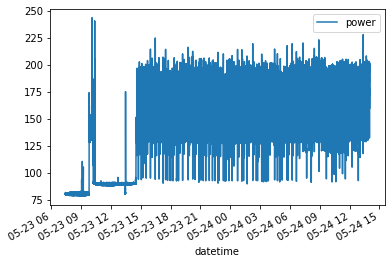

In [127]:
df['23-05-2022 07:25':'24-05-2022 14:00'].plot()

<AxesSubplot:xlabel='datetime'>

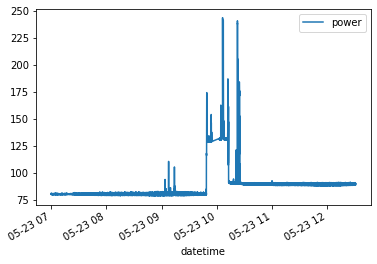

In [69]:
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [71]:
lower_power = df["23-05-2022 7:00" : "23-05-2022 9:00"]
higher_power = df["23-05-2022 10:30" : "23-05-2022 12:30"]

In [88]:
print(f"Lower avg: {lower_power.mean().values[0]}, higher avg: {higher_power.mean().values[0]}, diff: {higher_power.mean().values[0] - lower_power.mean().values[0]}")

Lower avg: 80.45737104135029, higher avg: 89.62018398118708, diff: 9.162812939836797


In [219]:
df.loc["23-05-2022 09:48"]

,power
datetime,
2022-05-23 09:48:00,79.900000
2022-05-23 09:48:01,79.800000
2022-05-23 09:48:02,80.500000
2022-05-23 09:48:03,81.300000
2022-05-23 09:48:04,81.100000
2022-05-23 09:48:05,80.750000
2022-05-23 09:48:06,79.750000
2022-05-23 09:48:07,80.250000
2022-05-23 09:48:08,81.000000


<AxesSubplot:xlabel='datetime'>

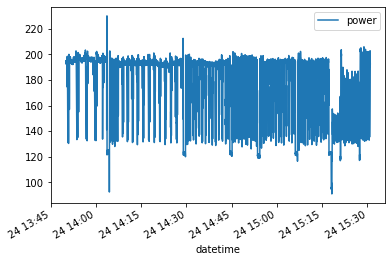

In [62]:
df['24-05-2022 13:50':'24-05-2022 15:30'].plot()

In [58]:
df.loc["24-05-2022 13:59"]

,power
datetime,
2022-05-24 13:59:00,195.9
2022-05-24 13:59:01,192.8
2022-05-24 13:59:02,189.1
2022-05-24 13:59:03,193.5
2022-05-24 13:59:04,184.0
2022-05-24 13:59:05,195.8
2022-05-24 13:59:06,194.6
2022-05-24 13:59:07,195.5
2022-05-24 13:59:08,197.0
